# Autoencoder

 A CCN based autoencoder.

 Steps:

 1. build an autoencoder
 2. cluster code

## Load dataset

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras_utils

In [9]:
def load_dataset():
    data = pd.read_csv("./datasets/our2/dataset_50_2.5.csv", header=None)
    labels = pd.read_csv("./datasets/our2/dataset_labels_50_2.5.csv", header=None)

    return data, labels

In [10]:
def print_stats(ds: pd.DataFrame):
    print(ds.shape)
    print(ds.head(1))

In [11]:
X_df, y_df = load_dataset()

In [12]:
print_stats(X_df)
print_stats(y_df)

(22589, 750)
   0    1    2    3    4    5    6    7    8    9    ...  740  741  742  743  \
0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ...  0.0  0.0  0.0  0.0   

   744  745  746  747  748  749  
0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 750 columns]
(22589, 3)
   0         1      2
0  a  nexus4_1  stand


## Preprocessing

In [13]:
def restructure(data):
    return data.reshape(6, 125)

def get_label(data):
    return data[2]

In [14]:
# Back to numpy
X = X_df.loc[:].to_numpy()
y = y_df.loc[:].to_numpy()

# Restructure the array
X = np.array(list(map(restructure, X)))

In [15]:
print(X.shape)
print(y.shape)

(22589, 6, 125)
(22589, 3)


In [16]:
assert X.shape == (y.shape[0], 6, 125), "Shape of X is invalid"
assert y.shape == (X.shape[0], 3), "Shape of y is invalid"

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

In [18]:
def plot_acc(x):
    plt.plot(x[0])
    plt.plot(x[1])
    plt.plot(x[2])

def plot_gyro(x):
    plt.plot(x[3])
    plt.plot(x[4])
    plt.plot(x[5])

def plot_sensors(x):
    plt.subplot(1, 2, 1)
    plot_acc(x)
    plt.subplot(1, 2, 2)
    plot_gyro(x)

X[11236]: stand


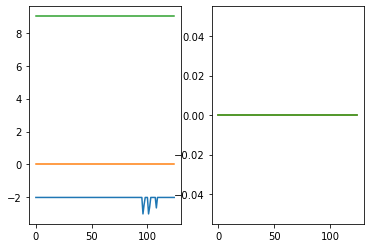

X[2407]: stairsup


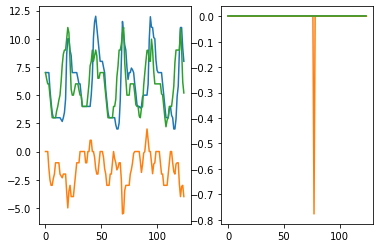

X[17329]: stairsup


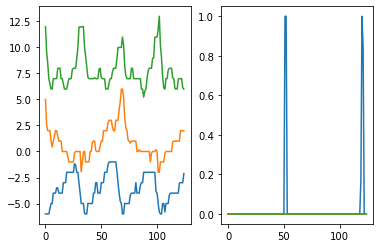

X[2188]: sit


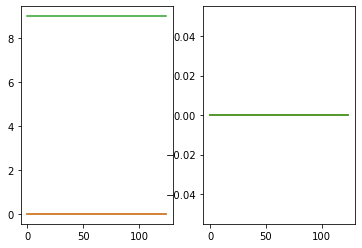

X[6951]: stairsup


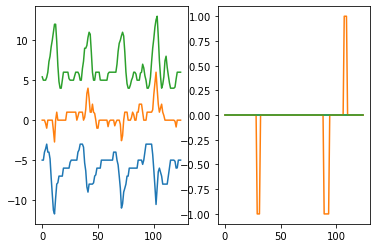

X[3076]: bike


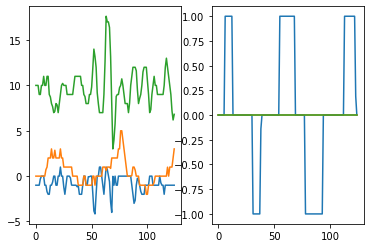

X[11968]: walk


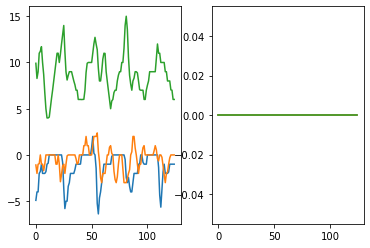

X[15613]: walk


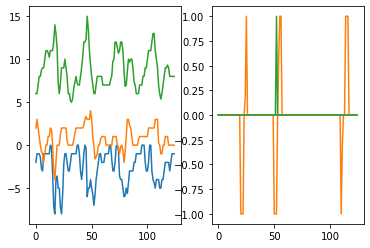

X[10582]: stand


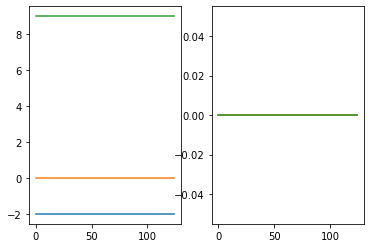

X[19920]: stand


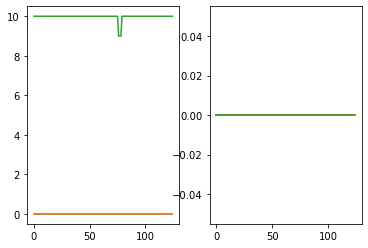

In [19]:
import random


for _ in range(10):
    i = random.randint(0, X.shape[0]) 
    x = restructure(X[i])

    print(f"X[{i}]: {get_label(y[i])}")
    plot_sensors(x)
    plt.show()

## Model

In [20]:
DATA_SHAPE = X.shape[1:]

In [21]:
def build_pca_autoencoder(data_shape, code_size):

    # encoder
    inputs = tf.keras.Input(data_shape)
    X = layers.Flatten()(inputs)
    outputs = layers.Dense(code_size, activation="linear")(X)
    encoder = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # decoder
    inputs = tf.keras.Input((code_size,))
    X = layers.Dense(np.prod(data_shape), activation="linear")(inputs)
    outputs = layers.Reshape(data_shape)(X)
    decoder = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return encoder, decoder

In [22]:
encoder, decoder = build_pca_autoencoder(DATA_SHAPE, 128)

encoder.summary()
decoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 125)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 750)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               96128     
Total params: 96,128
Trainable params: 96,128
Non-trainable params: 0
_________________________________________________________________
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 750)               96750     
____________________________

In [23]:
inputs = tf.keras.Input(DATA_SHAPE)
code = encoder(inputs)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inputs=inputs, outputs=reconstruction)

autoencoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6, 125)]          0         
_________________________________________________________________
functional_1 (Functional)    (None, 128)               96128     
_________________________________________________________________
functional_3 (Functional)    (None, 6, 125)            96750     
Total params: 192,878
Trainable params: 192,878
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder.compile(optimizer='adamax', loss='mse')

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks = [early_stopping_callback]

history = autoencoder.fit(x=X_train, y=X_train, epochs=100, validation_data=(X_test, X_test), callbacks=callbacks)

Epoch 1/100
495/495 [==============================] - 1s 2ms/step - loss: 1.6399 - val_loss: 0.9958
Epoch 2/100
495/495 [==============================] - 1s 2ms/step - loss: 0.8314 - val_loss: 0.7168
Epoch 3/100
495/495 [==============================] - 1s 2ms/step - loss: 0.6076 - val_loss: 0.5370
Epoch 4/100
495/495 [==============================] - 1s 2ms/step - loss: 0.4640 - val_loss: 0.4255
Epoch 5/100
495/495 [==============================] - 1s 2ms/step - loss: 0.3719 - val_loss: 0.3490
Epoch 6/100
495/495 [==============================] - 1s 2ms/step - loss: 0.3069 - val_loss: 0.2946
Epoch 7/100
495/495 [==============================] - 1s 2ms/step - loss: 0.2605 - val_loss: 0.2533
Epoch 8/100
495/495 [==============================] - 1s 2ms/step - loss: 0.2263 - val_loss: 0.2241
Epoch 9/100
495/495 [==============================] - 1s 2ms/step - loss: 0.2008 - val_loss: 0.2012
Epoch 10/100
495/495 [==============================] - 1s 2ms/step - loss: 0.1814 - val_lo

[]

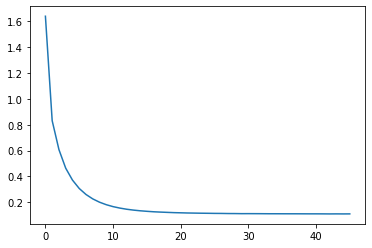

In [25]:
h = history.history
plt.plot(h['loss'])
plt.plot()

In [26]:
def visualize(sample, encoder, decoder):
    code = encoder.predict(sample[np.newaxis, :])[0]
    
    reco = decoder.predict(code[np.newaxis, :])[0]

    plt.subplot(1,3,1)
    plt.title("acc original")
    plot_acc(sample)

    plt.subplot(1,3,2)
    plt.title("code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("acc reconstructed")
    plot_acc(reco)

    plt.show()


PCA MSE: 0.11676789075136185


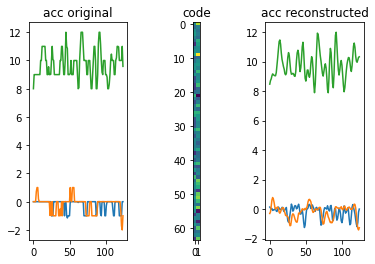

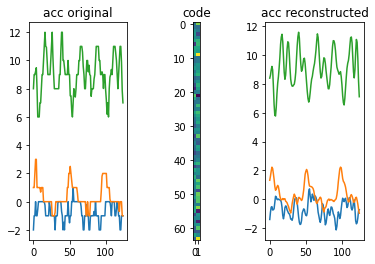

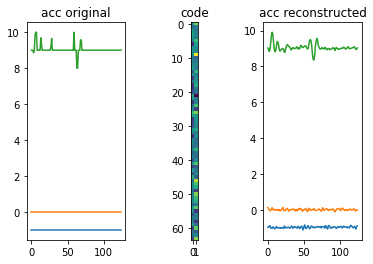

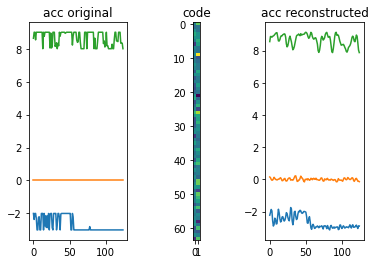

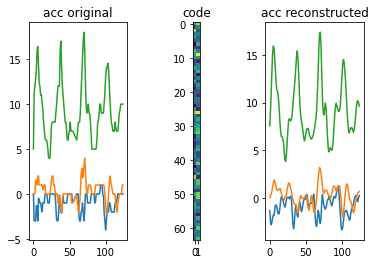

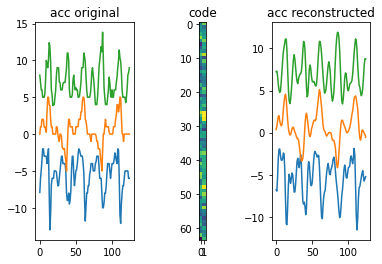

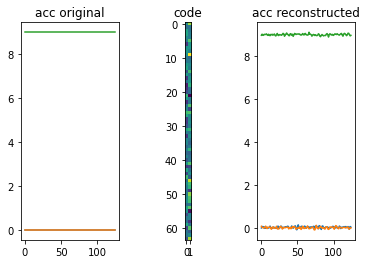

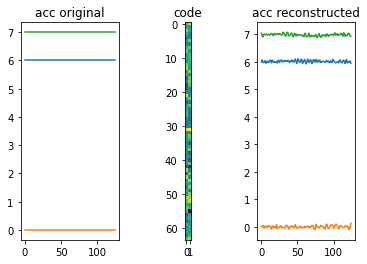

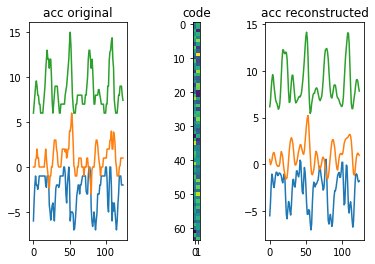

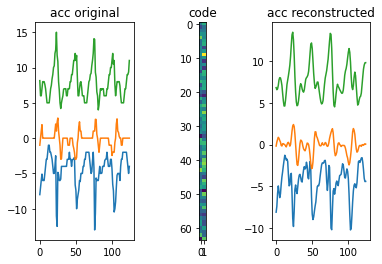

In [27]:
loss = autoencoder.evaluate(X_test, X_test, verbose=0)
print("PCA MSE:", loss)

for i in range(10):
    sample = X_test[i]
    visualize(sample, encoder, decoder)

## Model

In [54]:
print(DATA_SHAPE)

(6, 125)


In [72]:
def build_deep_autoencoder(data_shape, code_size):

    max_pool = layers.MaxPool1D(3, padding="same")

    # encoder
    inputs = tf.keras.Input(data_shape)

    X = layers.Conv1D(32, kernel_size=7, activation="relu", padding="same")(inputs)
    X = max_pool(X)

    X = layers.Conv1D(64, kernel_size=7, activation="relu", padding="same")(X)
    X = max_pool(X)

    X = layers.Conv1D(128, kernel_size=5, activation="relu", padding="same")(X)
    X = max_pool(X)

    X = layers.Conv1D(256, kernel_size=3, activation="relu", padding="same")(X)
    X = max_pool(X)

    X = layers.Flatten()(X)

    outputs = layers.Dense(code_size)(X)
    
    encoder = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # decoder
    #inputs = tf.keras.Input((code_size,))
    #X = layers.Dense(6*125, activation="elu")(inputs)
    #X = layers.Reshape((6,125))(X)
    #X = layers.Conv1DTranspose(128, kernel_size=(1,3), strides=(1,3), activation="relu", padding="same")(X)
    #X = layers.Conv2DTranspose(64, kernel_size=(1,3), strides=(1,3), activation="relu", padding="same")(X)
    #X = layers.Conv2DTranspose(32, kernel_size=(1,3), strides=(1,3), activation="relu", padding="same")(X)
    #outputs = layers.Conv2DTranspose(6, kernel_size=(1,3), strides=(1,3), activation=None, padding="same")(X)
    #decoder = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return encoder, decoder

In [73]:
encoder, decoder = build_deep_autoencoder(DATA_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

ValueError: Input 0 of layer conv2d_5 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 6, 125]

In [30]:
inp = tf.keras.Input(DATA_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)

autoencoder.compile(optimizer="adamax", loss='mse')

In [31]:
model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None

In [32]:
autoencoder.fit(x=X_train, y=X_train, epochs=25, validation_data=(X_test, X_test), 
                callbacks=[keras_utils.ModelSaveCallback(model_filename)],
                verbose=0, initial_epoch=last_finished_epoch or 0)

Epoch 0 - Model saved in autoencoder_network.hdf5
Epoch 1 - Model saved in autoencoder_network.hdf5
Epoch 2 - Model saved in autoencoder_network.hdf5
Epoch 3 - Model saved in autoencoder_network.hdf5
Epoch 4 - Model saved in autoencoder_network.hdf5
Epoch 5 - Model saved in autoencoder_network.hdf5
Epoch 6 - Model saved in autoencoder_network.hdf5
Epoch 7 - Model saved in autoencoder_network.hdf5
Epoch 8 - Model saved in autoencoder_network.hdf5
Epoch 9 - Model saved in autoencoder_network.hdf5
Epoch 10 - Model saved in autoencoder_network.hdf5
Epoch 11 - Model saved in autoencoder_network.hdf5
Epoch 12 - Model saved in autoencoder_network.hdf5
Epoch 13 - Model saved in autoencoder_network.hdf5
Epoch 14 - Model saved in autoencoder_network.hdf5
Epoch 15 - Model saved in autoencoder_network.hdf5
Epoch 16 - Model saved in autoencoder_network.hdf5
Epoch 17 - Model saved in autoencoder_network.hdf5
Epoch 18 - Model saved in autoencoder_network.hdf5
Epoch 19 - Model saved in autoencoder_net

In [33]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

Convolutional autoencoder MSE: 1.5367969274520874
